In [3]:
import matplotlib.pyplot as plt
import numpy
import pandas
import functools 
import datetime
import scipy

import pmana.utils

#### Look at one single measurement

There were 4 used channels in this measurement.


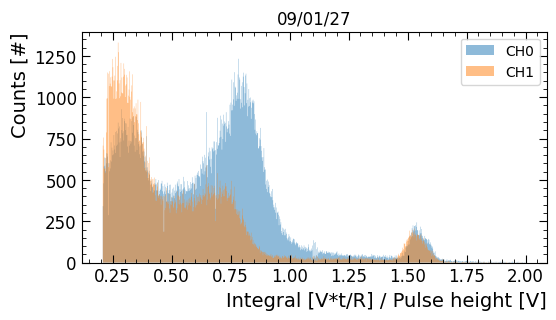

In [68]:
fig, ax = plt.subplots(figsize=(6,3))

YEAR = '2026'
MONTH = 'Jan'
MEASUREMENT = '09/01/27'
# extract a measurement 
Data = pmana.utils.io.ExtractSingleMeasurement(
    f"../../data/cern/{YEAR}_{MONTH}/{MEASUREMENT}/",
    DELIMITER = ","
)
print(f"There were {len(Data)} used channels in this measurement.")

CHs = [1, 2]
for ch in CHs:
    # plot channel data
    pmana.utils.plotting.PlotSingleChannel(
        Data[ch-1],
        ax,
        channel = ch-1,
        rebin = False,
        debug = False,
        DISPLAY_FIT = False
    )

ax = pmana.utils.plotting.UpdateMatplotlibStyle(
    ax,
    "Integral [V*t/R] / Pulse height [V]",
    "Counts [#]"
)

ax.legend()
ax.set_title(f"{MEASUREMENT}")
plt.show()


There were 4 used channels in this measurement.


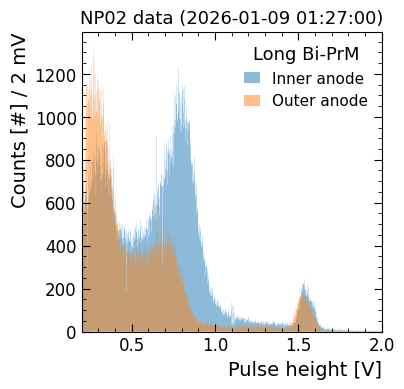

In [200]:
fig, ax = plt.subplots(figsize=(4, 4))

plt.subplots_adjust(
    left=0.2,
    right=0.95,
    bottom=0.15,
    top=0.9
)

YEAR = '2026'
MONTH = 'Jan'
MEASUREMENT = '09/01/27'
# extract a measurement 
Data = pmana.utils.io.ExtractSingleMeasurement(
    f"../../data/cern/{YEAR}_{MONTH}/{MEASUREMENT}/",
    DELIMITER = ","
)
print(f"There were {len(Data)} used channels in this measurement.")

CHs = [1, 2]
for ch in CHs:
    # plot channel data
    pmana.utils.plotting.PlotSingleChannel(
        Data[ch-1],
        ax,
        channel = ch-1,
        rebin = False,
        debug = False,
        DISPLAY_FIT = False
    )

ax = pmana.utils.plotting.UpdateMatplotlibStyle(
    ax,
    "Pulse height [V]",
    "Counts [#] / 2 mV"
)

# tweak legend
leg = ax.legend(handlelength=1, frameon=False, title='Long Bi-PrM', fontsize=11)
leg.get_title().set_fontsize('13')
for text, new_label in zip(leg.get_texts(), ['Inner anode', 'Outer anode']):
    text.set_text(new_label)

# nice title
DATE = datetime.datetime(2026, 1, 9, 1, 27)
ax.set_title(f"NP02 data ({DATE})", fontsize=13)
ax.set_xlim(0.2, 2.0)

plt.show()
fig.savefig('../../plots/review/ExampleSpectra.pdf')

#### Calibration

In several campaigns, a test pulse is sent to the channels of each purity monitor. The test pulse serves as a reference, clean, isolated peak (usually, >1 V) we can use to cross-calibrate different channels. Moreover, we can correlate the test pulse trend as function of the temperature to understand the correlation, remove the temperature dependence statistically, and extract the systematic uncertainty on the anode measurements (given that the statistical contribution is negligble for large enough datasets).

In [95]:
TIME_DIR = f"2025_Nov"
PATH_CAMPAIGN = f"../../data/cern/{TIME_DIR}"
PATH_TEMPERATURES = f"../../data/cern/NP02_Apr_Oct_Jan.csv"

In [96]:
# get temperature mapping
Temperatures = pmana.utils.io.ExtractTemperatureMonitoring(
    PATH_TEMPERATURES,
    IsPadova = False,
    delimiter = "\t",
    skiprows = 1,
    # usecols = [0, 1],
    names = ["Date", "T"]
)

# some more formatting...
Temperatures['Date'] = pandas.to_datetime(
    Temperatures['Date'],
    unit='ms',
    utc=True
)
Temperatures = Temperatures.drop_duplicates()
Temperatures = Temperatures.sort_values(by=['Date'])

In [97]:
# analyze campaign
Output = pmana.utils.anatestdata.IterateCERN(
    PATH_CAMPAIGN,  ###< path to data
    # pmana.utils.anatestdata.AnalyzeMeasurement, 
    functools.partial(
        pmana.utils.anatestdata.GaussianFitToChannel, 
        IS_DT5781=False, rebin=False, debug=False,
        MASK_TESTPULSE = True, DELIMITER = ',', SKIP_NROWS = 4, 
        BINNAME = 'BinCenter', COUNTNAME = 'Population'
    ),  ###< analyzing module, changing some options 
    YEAR = 2025,
    MONTH = 11
)

# convert top DataFrame
Output = pandas.DataFrame(Output)

In [98]:
# re-format the dataframe
Output.columns = ["Peak_CH1", "Err_Peak_CH1", "Width_CH1", "Err_Width_CH1",
                  "Peak_CH2", "Err_Peak_CH2", "Width_CH2", "Err_Width_CH2", 
                  "Peak_CH3", "Err_Peak_CH3", "Width_CH3", "Err_Width_CH3", 
                  # "Peak_CH4", "Err_Peak_CH4", "Width_CH4", "Err_Width_CH4", 
                  "Date"]

# sort by date
Output.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

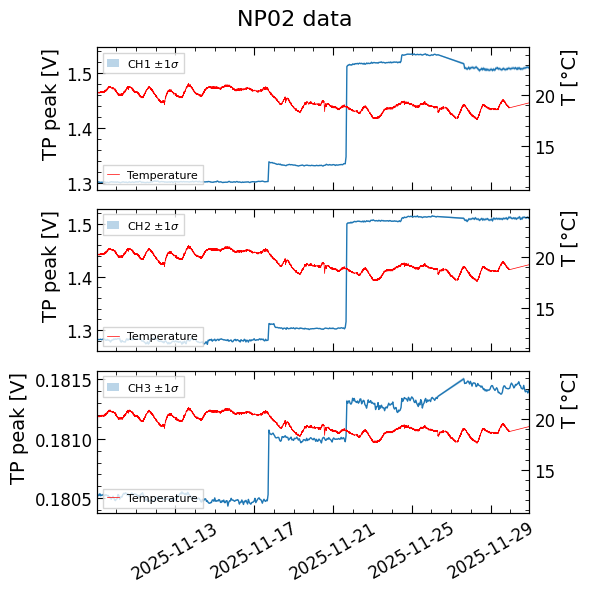

In [99]:
fig, ax = plt.subplots(figsize=(6, 2.*3), nrows=3, layout='tight')

# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1)
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'TP peak [V]')
ax[0].set_xticklabels([])

# CH2
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1)
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3, label='CH2 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'TP peak [V]')
ax[1].set_xticklabels([])

# CH3
ax[2].plot(Output.Date, Output.Peak_CH3.astype(float), lw=1)
ax[2].fill_between(Output.Date, Output.Peak_CH3-Output.Err_Peak_CH3,  Output.Peak_CH3+Output.Err_Peak_CH3, alpha=0.3, label='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'TP peak [V]')
# ax[2].set_xticklabels([])

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.plot(Temperatures['Date'], Temperatures['T'], c='red', label='Temperature', lw=0.5, zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

fig.suptitle(f'NP02 data', fontsize=16)

plt.show()
fig.savefig(f"../../plots/cern/Calibration_TestPulseTrend_{TIME_DIR}.png", dpi=300, bbox_inches='tight')

#### Temperature dependence

By interpolating the temperature trend, we can carry out a complete voltage-temperature correlation study.

To study the correlation, keep in mind that:
* using a large period of time could introduce fake correlations;
* using a small period of time introduces more statistical fluctuations in the procedure, and often won't capture temperature changes (e.g., daily fluctuations).

In [100]:
# Interpolate temperatures to generalize
Temperatures['Date_s'] = Temperatures["Date"].astype("int64") / 1e9 ###< seconds from epoch, 1970-01-01
Output['Date_s'] = Output["Date"].astype("int64") / 1e9

TempVsTime = scipy.interpolate.interp1d(
  Temperatures['Date_s'],
  Temperatures['T'],
  kind = 'linear'
)
Output['T'] = TempVsTime(Output['Date_s'])

/Users/triozzi/Analysis/pmana/pmana/utils/plotting.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=True, fancybox=False, handlelength=1, loc='best')


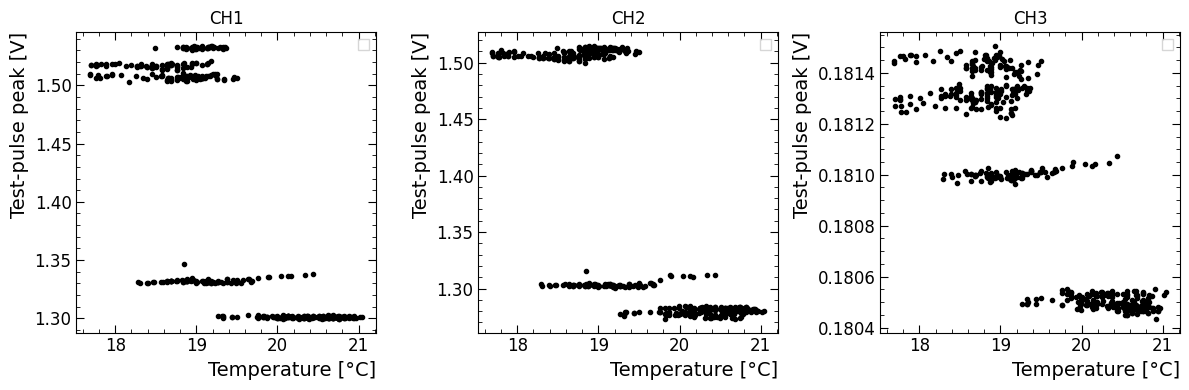

In [101]:
fig, axes = plt.subplots(figsize=(4*3, 4), ncols=3, layout='tight')

for i, ax in enumerate(axes):
  ax.scatter(Output['T'], Output[f'Peak_CH{i+1}'], marker = '.', c='black')
  
  pmana.utils.plotting.UpdateMatplotlibStyle(ax, f'Temperature [°C]', f'Test-pulse peak [V]')
  ax.set_title(f'CH{i+1}')

plt.show()

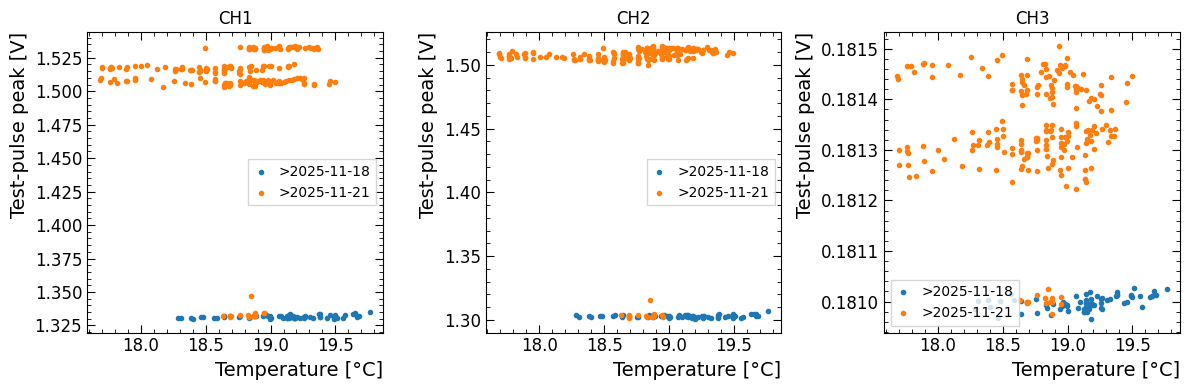

In [113]:
fig, axes = plt.subplots(figsize=(4*3, 4), ncols=3, layout='tight')

DateLowLimits = [
  # november
  datetime.datetime(2025, 11, 18),
  datetime.datetime(2025, 11, 21)
  # # december
  # datetime.datetime(2025, 12, 5),
  # datetime.datetime(2025, 12, 11),
  # datetime.datetime(2025, 12, 19),
  # datetime.datetime(2025, 12, 24)
  # # january
  # datetime.datetime(2026, 1, 1),
  # datetime.datetime(2026, 1, 6, 12),
  # datetime.datetime(2026, 1, 13, 12),
  # datetime.datetime(2026, 1, 15)
  # # january v2
  # datetime.datetime(2026, 1, 17),
  # datetime.datetime(2026, 1, 21),
]

for i in range(len(DateLowLimits)):

  LowDate = DateLowLimits[i]
  
  if i+1 == len(DateLowLimits):
    HighDate = datetime.datetime(2026, 1, 1)
  else:
    HighDate = DateLowLimits[i+1]

  for i, ax in enumerate(axes):
    Mask = (Output['Date'] > LowDate) & (Output['Date'] < HighDate)
    ax.scatter(Output[Mask]['T'], Output[Mask][f'Peak_CH{i+1}'], marker = '.', label=f'>{LowDate.strftime('%Y-%m-%d')}')
    
    pmana.utils.plotting.UpdateMatplotlibStyle(ax, f'Temperature [°C]', f'Test-pulse peak [V]')
    ax.set_title(f'CH{i+1}')

plt.show()

In [114]:
def linear(T, a, b):
    return a*T + b

def quadratic(T, a, b, c):
    return a*T**2 + b*T + c

# bands from covariances
def linear_band(T, cov):
    da2 = cov[0, 0]
    db2 = cov[1, 1]
    dab = cov[0, 1]
    return numpy.sqrt(T**2 * da2 + db2 + 2*T*dab)

def quadratic_band(T, cov):
    var = (
        (T**2)**2 * cov[0, 0] +
        T**2 * cov[1, 1] +
        cov[2, 2] +
        2*T**3 * cov[0, 1] +
        2*T**2 * cov[0, 2] +
        2*T * cov[1, 2]
    )
    return numpy.sqrt(var)

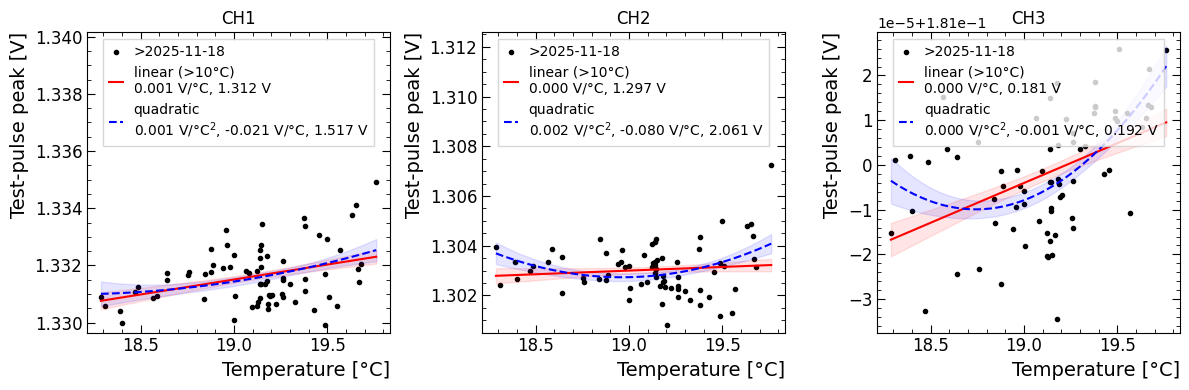

In [119]:
fig, axes = plt.subplots(figsize=(4*3, 4), ncols=3, layout='tight')

# november
LowDate = datetime.datetime(2025, 11, 18)
HighDate = datetime.datetime(2025, 11, 21)
Mask = (Output['Date'] > LowDate) & (Output['Date'] < HighDate)
# # december
# LowDate = datetime.datetime(2026, 1, 17)
# HighDate = datetime.datetime(2026, 1, 21)
# Mask = (Output['Date'] > LowDate) & (Output['Date'] < HighDate)
# # january
# LowDate = datetime.datetime(2026, 1, 6, 12)
# Mask = (Output['Date'] > LowDate) 

LinearCalibration = []
QuadraticCalibration = []

for i, ax in enumerate(axes):

  # scatter
  ax.scatter(Output[Mask]['T'], Output[Mask][f'Peak_CH{i+1}'], marker = '.', c='black', label=f'>{LowDate.strftime('%Y-%m-%d')}')
  
  # fits
  x = Output[Mask]['T'].values
  y = Output[Mask][f'Peak_CH{i+1}'].values

  ## linear
  # november
  Temp = 10
  MaskFit = (x > Temp)
  # # december
  # MaskFit = (x < 100)
  # # january
  # Temp = 17
  # MaskFit = (x < HighTemp)
  par, cov = scipy.optimize.curve_fit(linear, x[MaskFit], y[MaskFit]); LinearCalibration.append(par)
  domain = numpy.linspace(min(x), max(x), 100)
  ax.plot(domain, linear(domain, *par), c='red', lw=1.5, 
          label=f'linear (>{Temp}°C)\n{par[0]:.3f} V/°C, {par[1]:.3f} V')
  err_lin = linear_band(domain, cov)
  ax.fill_between(domain, linear(domain, *par) - err_lin, linear(domain, *par) + err_lin, color='red', alpha=0.1)
  
  ### poly
  parpoly, covpoly = scipy.optimize.curve_fit(quadratic, x, y); QuadraticCalibration.append(parpoly)
  ax.plot(domain, quadratic(domain, *parpoly), c='blue', lw=1.5, ls='--', 
          label=f'quadratic\n{parpoly[0]:.3f} V/°C$^2$, {parpoly[1]:.3f} V/°C, {parpoly[2]:.3f} V')
  err_lin = quadratic_band(domain, covpoly)
  ax.fill_between(domain, quadratic(domain, *parpoly) - err_lin, quadratic(domain, *parpoly) + err_lin, color='blue', alpha=0.1)
  
  pmana.utils.plotting.UpdateMatplotlibStyle(ax, f'Temperature [°C]', f'Test-pulse peak [V]')
  ax.legend(loc='upper center', fancybox=False, handlelength=1)
  if i != 2:
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.005)
  ax.set_title(f'CH{i+1}')

plt.show()

In [120]:
def ApplyCalibration(peak, T, par, mode='linear'):

  if mode == 'linear':
    if len(par) != 2:
      raise Exception(f'Cannot apply {mode} calibration with {len(par)} fit parameters.')

    a, b = par
    fT  = a*T  + b
    fT0 = a*T[0] + b

  elif mode == 'quadratic':

    if len(par) != 3:
      raise Exception(f'Cannot apply {mode} calibration with {len(par)} fit parameters.')
    
    a, b, c = par
    fT  = a*T**2  + b*T  + c
    fT0 = a*T[0]**2 + b*T[0] + c

  else:
    raise ValueError(f'Unknown calibration mode: {mode}')
  
  peak_calibrated = peak - (fT - fT0)

  return peak_calibrated

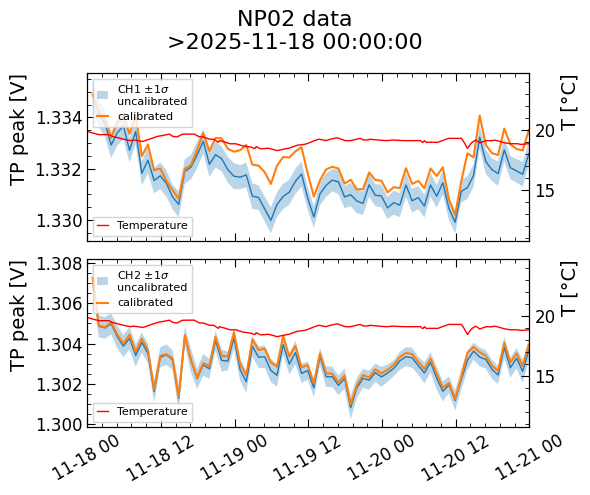

In [121]:
fig, ax = plt.subplots(figsize=(6, 2.5*2), nrows=2, layout='tight')

# november
LowDate = datetime.datetime(2025, 11, 18)
HighDate = datetime.datetime(2025, 11, 21)
Mask = (Output.Date > LowDate) & (Output.Date < HighDate)
# # december 
# LowDate = datetime.datetime(2025, 12, 1)
# Mask = (Output.Date > LowDate)
# # juanary
# LowDate = datetime.datetime(2026, 1, 17)
# HighDate = datetime.datetime(2026, 1, 21)
# Mask = (Output.Date > LowDate) & (Output.Date < HighDate)
OutputMasked = Output[Mask].copy()

# the time range is important: you need a reference temperature
OutputMasked['Peak_CH1_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  LinearCalibration[0]
)

OutputMasked['Peak_CH2_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  LinearCalibration[1]
)

# quadratic calibration
OutputMasked['Peak_CH1_Cal_Poly'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  QuadraticCalibration[0],
  'quadratic'
)

OutputMasked['Peak_CH2_Cal_Poly'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  QuadraticCalibration[1],
  'quadratic'
)

# CH1
ax[0].plot(OutputMasked.Date, OutputMasked.Peak_CH1, lw=1)
ax[0].fill_between(OutputMasked.Date, OutputMasked.Peak_CH1-OutputMasked.Err_Peak_CH1,  OutputMasked.Peak_CH1+OutputMasked.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$\nuncalibrated')
ax[0].plot(OutputMasked.Date, OutputMasked.Peak_CH1_Cal, lw=1.5, label='calibrated')
# ax[0].plot(OutputMasked.Date, OutputMasked.Peak_CH1_Cal_Poly, lw=1.5, ls=':', label='quadratic')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'TP peak [V]')
ax[0].set_xticklabels([])

# CH2
ax[1].plot(OutputMasked.Date, OutputMasked.Peak_CH2, lw=1)
ax[1].fill_between(OutputMasked.Date, OutputMasked.Peak_CH2-OutputMasked.Err_Peak_CH2,  OutputMasked.Peak_CH2+OutputMasked.Err_Peak_CH2, alpha=0.3, label='CH2 $\\pm1\\sigma$\nuncalibrated')
ax[1].plot(OutputMasked.Date, OutputMasked.Peak_CH2_Cal, lw=1.5, label='calibrated')
# ax[1].plot(OutputMasked.Date, OutputMasked.Peak_CH2_Cal_Poly, lw=1.5, ls=':', label='quadratic')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'TP peak [V]')

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(LowDate, HighDate)

    # plot temperatures
    a2 = a.twinx()
    a2.plot(Temperatures['Date'][::10], Temperatures['T'][::10], c='red', label='Temperature', zorder=-3, lw=1)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

fig.suptitle(f'NP02 data\n>{LowDate}', fontsize=16)

plt.show()

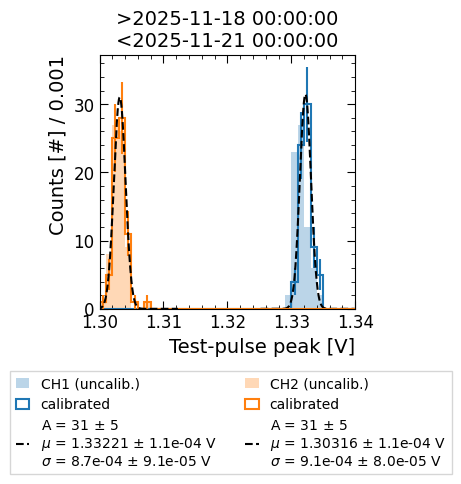

In [123]:
fig, ax = plt.subplots(figsize=(3.3, 3.3))

# november
width = 0.001; binning = numpy.arange(1.3, 1.34+width, width)
LowDate = datetime.datetime(2025, 11, 18)
HighDate = datetime.datetime(2025, 11, 21)
Mask = Output.Date.between(LowDate, HighDate)

# # december
# width = 0.001; binning = numpy.arange(1.51, 1.535+width, width)
# LowDate = datetime.datetime(2025, 12, 5)
# HighDate = datetime.datetime(2025, 12, 11)
# Mask = Output.Date.between(LowDate, HighDate)

# # january
# width = 0.0005; binning = numpy.arange(1.52, 1.54+width, width)
# LowDate = datetime.datetime(2026, 1, 17)
# HighDate = datetime.datetime(2026, 1, 21)
# Mask = Output.Date.between(LowDate, HighDate)

OutputMasked = Output[Mask].copy()

# the time range is important: you need a reference temperature
OutputMasked['Peak_CH1_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  LinearCalibration[0]
)

OutputMasked['Peak_CH2_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  LinearCalibration[1]
)

# CH1
ax.hist(OutputMasked.Peak_CH1, bins=binning, histtype='stepfilled', fc='C0', alpha=0.3, label='CH1 (uncalib.)')

# CH1 -- calibrated
counts, edges, _ = ax.hist(OutputMasked.Peak_CH1_Cal, bins=binning, histtype='step', linewidth=1.5, color='C0', label='calibrated')
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C0', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(OutputMasked.Peak_CH1_Cal), numpy.std(OutputMasked.Peak_CH1_Cal)]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(min(OutputMasked.Peak_CH1_Cal)-0.005, max(OutputMasked.Peak_CH1_Cal)+0.005, 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=1.5, ls='--', c='black',
        label = f'A = {par[0]:.0f} $\\pm$ {err[0]:.0f}\n$\\mu$ = {par[1]:.5f} $\\pm$ {err[1]:.1e} V\n$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')

# CH2
ax.hist(OutputMasked.Peak_CH2, bins=binning, histtype='stepfilled', fc='C1', alpha=0.3, label='CH2 (uncalib.)')

# CH2 -- calibrated
counts, edges, _ = ax.hist(OutputMasked.Peak_CH2_Cal, bins=binning, histtype='step', linewidth=1.5, color='C1', label='calibrated')
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C1', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(OutputMasked.Peak_CH2_Cal), numpy.std(OutputMasked.Peak_CH2_Cal)]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(min(OutputMasked.Peak_CH2_Cal)-0.005, max(OutputMasked.Peak_CH2_Cal)+0.005, 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=1.5, ls='--', c='black', 
        label = f'A = {par[0]:.0f} $\\pm$ {err[0]:.0f}\n$\\mu$ = {par[1]:.5f} $\\pm$ {err[1]:.1e} V\n$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Test-pulse peak [V]', f'Counts [#] / {width}')
ax.legend(loc=(-0.35, -0.65), handlelength=1, ncol=2, fancybox=False)
ax.set_xlim(binning[0], binning[-1])
ax.set_title(f'>{LowDate}\n<{HighDate}', fontsize=14)

plt.show()

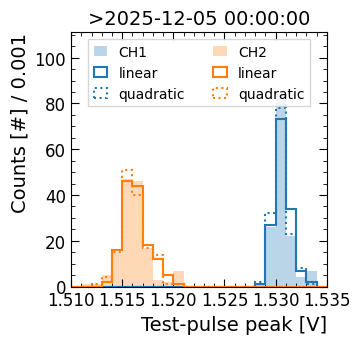

In [26]:
fig, ax = plt.subplots(figsize=(3.3, 3.3))

# december
width = 0.001; binning = numpy.arange(1.51, 1.535+width, width)
LowDate = datetime.datetime(2025, 12, 5)
HighDate = datetime.datetime(2025, 12, 11)
Mask = Output.Date.between(LowDate, HighDate)

# # january
# width = 0.001; binning = numpy.arange(1.525, 1.55+width, width)
# LowDate = datetime.datetime(2026, 1, 6, 12)
# HighDate = datetime.datetime(2026, 1, 13, 12)
# Mask = Output.Date.between(LowDate, HighDate)

OutputMasked = Output[Mask].copy()

# the time range is important: you need a reference temperature
OutputMasked['Peak_CH1_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  LinearCalibration[0]
)

OutputMasked['Peak_CH2_Cal'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  LinearCalibration[1]
)

# quadratic calibration
OutputMasked['Peak_CH1_Cal_Poly'] = ApplyCalibration(
  OutputMasked['Peak_CH1'].values,
  OutputMasked['T'].values,
  QuadraticCalibration[0],
  'quadratic'
)

OutputMasked['Peak_CH2_Cal_Poly'] = ApplyCalibration(
  OutputMasked['Peak_CH2'].values,
  OutputMasked['T'].values,
  QuadraticCalibration[1],
  'quadratic'
)

# CH1
ax.hist(OutputMasked.Peak_CH1, bins=binning, histtype='stepfilled', color='C0', alpha=0.3, label='CH1')
counts, edges, _ = ax.hist(OutputMasked.Peak_CH1_Cal, bins=binning, histtype='step', linewidth=1.5, color='C0', label='linear')
counts, edges, _ = ax.hist(OutputMasked.Peak_CH1_Cal_Poly, bins=binning, histtype='step', linestyle=':', linewidth=1.5, color='C0', label='quadratic')

# CH2
ax.hist(OutputMasked.Peak_CH2, bins=binning, histtype='stepfilled', color='C1', alpha=0.3, label='CH2')
counts, edges, _ = ax.hist(OutputMasked.Peak_CH2_Cal, bins=binning, histtype='step', linewidth=1.5, color='C1', label='linear')
counts, edges, _ = ax.hist(OutputMasked.Peak_CH2_Cal_Poly, bins=binning, histtype='step', linestyle=':', linewidth=1.5, color='C1', label='quadratic')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Test-pulse peak [V]', f'Counts [#] / {width}')
ax.legend(loc='upper center', fontsize=10, handlelength=1, ncol=2, fancybox=False)
ax.set_ylim(0, max(counts+60))
ax.set_xlim(binning[0], binning[-1])
ax.set_title(f'>{LowDate}', fontsize=14)

plt.show()

In [124]:
### only run this with November data
NOVEMBER_TEST_PULSE_CH1 = OutputMasked.Peak_CH1_Cal
NOVEMBER_TEST_PULSE_CH2 = OutputMasked.Peak_CH2_Cal

In [94]:
### only run this with January data
JANUARY_TEST_PULSE_CH1 = OutputMasked.Peak_CH1_Cal
JANUARY_TEST_PULSE_CH2 = OutputMasked.Peak_CH2_Cal

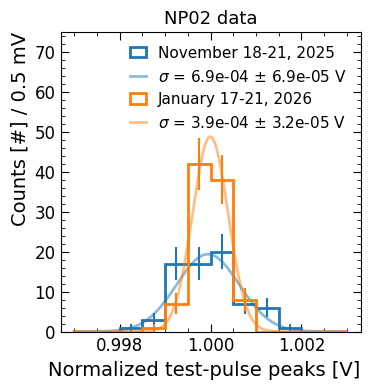

In [202]:
### comparison
fig, ax = plt.subplots(figsize=(4, 4))

plt.subplots_adjust(
    left=0.2,
    right=0.95,
    bottom=0.15,
    top=0.9
)

width = 0.0005; binning = numpy.arange(0.997, 1.003+width, width)

### November
counts, edges, _ = ax.hist(NOVEMBER_TEST_PULSE_CH1 / numpy.mean(NOVEMBER_TEST_PULSE_CH1), bins = binning, color='C0', histtype='step', linewidth=2, label='November 18-21, 2025', density=False)
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C0', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(NOVEMBER_TEST_PULSE_CH1 / numpy.mean(NOVEMBER_TEST_PULSE_CH1)), numpy.std(NOVEMBER_TEST_PULSE_CH1 / numpy.mean(NOVEMBER_TEST_PULSE_CH1))]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(binning[0], binning[-1], 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=2, ls='-', c='C0', alpha=0.5, 
        label = f'$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')

### January
counts, edges, _ = ax.hist(JANUARY_TEST_PULSE_CH1 / numpy.mean(JANUARY_TEST_PULSE_CH1), bins=binning, histtype='step', color='C1', linewidth=2, label='January 17-21, 2026', density=False)
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C1', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(JANUARY_TEST_PULSE_CH1 / numpy.mean(JANUARY_TEST_PULSE_CH1)), numpy.std(JANUARY_TEST_PULSE_CH1 / numpy.mean(JANUARY_TEST_PULSE_CH1))]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(binning[0], binning[-1], 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=2, ls='-', c='C1', alpha=0.5, 
        label = f'$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')


# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Normalized test-pulse peaks [V]', f'Counts [#] / 0.5 mV')
ax.legend(fontsize=11, handlelength=1, frameon=False, loc='upper right')
ax.set_title(f"NP02 data", fontsize=13)

# tweaks
ax.set_ylim(0, 75)

fig.savefig('../../plots/review/TestPulseChange.pdf')

#### Apply calibration to Bi-207 data

In [19]:
PATH_IC = '/Users/triozzi/Analysis/PurityMonitors/output/ICPeak_Dec_Jan.pkl'

In [20]:
# read data
PurityData = pandas.read_pickle(PATH_IC)

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

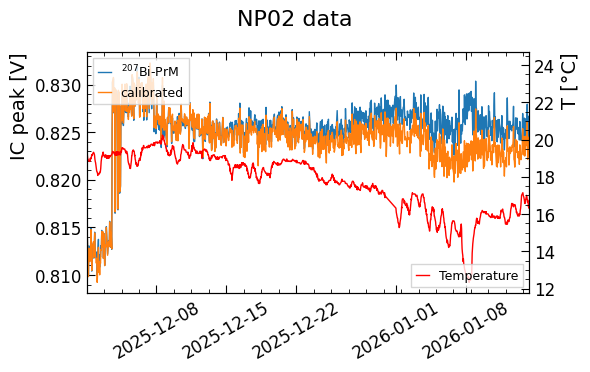

In [21]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

# december
OutputMasked = PurityData.copy()

# january
# LowDate = datetime.datetime(2026, 1, 6, 12)
# HighDate = datetime.datetime(2026, 1, 13, 12)
# Mask = (PurityData.Date > LowDate) & (PurityData.Date < HighDate)
# OutputMasked = PurityData[Mask].copy()

# the time range is important: you need a reference temperature
OutputMasked['ShortIC_Cal'] = ApplyCalibration(
  OutputMasked['ShortIC'].values,
  OutputMasked['T'].values,
  LinearCalibration[0]
)

ax.plot(OutputMasked.Date, OutputMasked.ShortIC, lw=1, label='$^{207}$Bi-PrM')
ax.plot(OutputMasked.Date, OutputMasked.ShortIC_Cal, lw=1, label='calibrated')
# ax[0].plot(OutputMasked.Date, OutputMasked.Peak_CH1_Cal_Poly, lw=1.5, ls=':', label='quadratic')
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'IC peak [V]')

# gfx
ax.legend(frameon=True, fancybox=False, handlelength=1, fontsize=9, loc='upper left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(min(OutputMasked['Date']), max(OutputMasked['Date']))

# plot temperatures
a2 = ax.twinx()
a2.plot(Temperatures['Date'][::10], Temperatures['T'][::10], c='red', label='Temperature', zorder=-3, lw=1)
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=9, loc='lower right')

# fig.suptitle(f'NP02 data\n>{LowDate}\n<{HighDate}', fontsize=16)
fig.suptitle(f'NP02 data', fontsize=16)

plt.show()

/var/folders/j_/p25pntkj5wb56cfcr5f3blr00000gn/T/ipykernel_40635/2109977589.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Rolling = OutputMasked.set_index('Date')['ShortIC_Cal'].rolling('8H').mean()


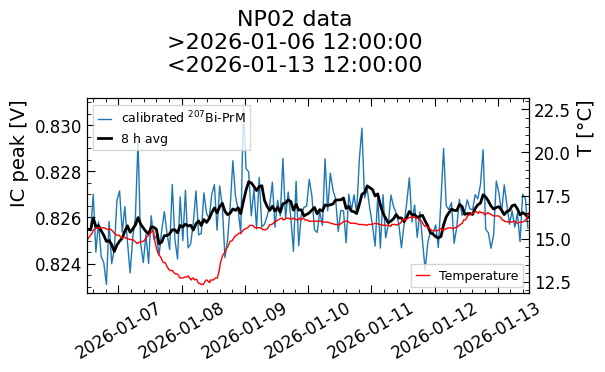

In [26]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2026, 1, 6, 12)
HighDate = datetime.datetime(2026, 1, 13, 12)
Mask = (PurityData.Date > LowDate) & (PurityData.Date < HighDate)
OutputMasked = PurityData[Mask].copy()

# the time range is important: you need a reference temperature
OutputMasked['ShortIC_Cal'] = ApplyCalibration(
  OutputMasked['ShortIC'].values,
  OutputMasked['T'].values,
  LinearCalibration[0]
)

ax.plot(OutputMasked.Date, OutputMasked.ShortIC_Cal, lw=1, label='calibrated $^{207}$Bi-PrM')
Rolling = OutputMasked.set_index('Date')['ShortIC_Cal'].rolling('8H').mean()
ax.plot(Rolling.index, Rolling.values, c='black', lw=2, label='8 h avg')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'IC peak [V]')
ax.legend(frameon=True, fancybox=False, handlelength=1, fontsize=9, loc='upper left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)

# plot temperatures
a2 = ax.twinx()
a2.plot(Temperatures['Date'][::10], Temperatures['T'][::10], c='red', label='Temperature', zorder=-3, lw=1)
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=9, loc='lower right')

fig.suptitle(f'NP02 data\n>{LowDate}\n<{HighDate}', fontsize=16)

plt.show()

#### Correlate with UV-Prm

In [17]:
UV_PURITY_DATA = "../../data/cern/prm_Top_lifetime_data_Gain_InducedCurrent_TPC.csv"

In [18]:
UVData = pandas.read_csv(
  UV_PURITY_DATA,
  delimiter = ',',
  names = ['Date', 'PM', 'Center', 'High', 'Low'],
  skiprows=1 
)

# some more formatting...
UVData['Date'] = pandas.to_datetime(
    UVData['Date']
)

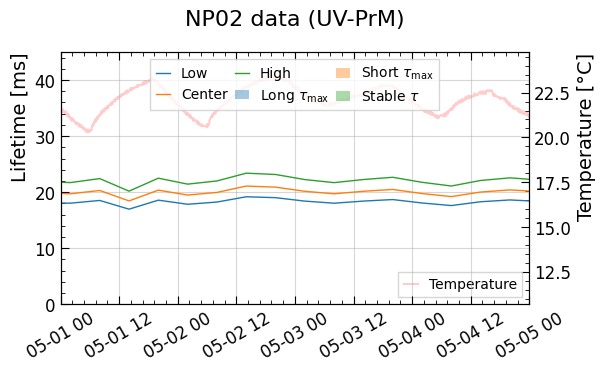

In [19]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

ax.plot(UVData.Date, UVData.Low, lw=1, label='Low')
ax.plot(UVData.Date, UVData.Center, lw=1, label='Center')
ax.plot(UVData.Date, UVData.High, lw=1, label='High')
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')

# highlight windows
ax.axvspan(datetime.datetime(2025, 1, 13), datetime.datetime(2025, 1, 15), zorder=-3, fc='C0', alpha=0.4, label='Long $\\tau_\\mathrm{max}$') # long PrM
ax.axvspan(datetime.datetime(2025, 5, 20), datetime.datetime(2025, 5, 22), zorder=-3, fc='C1', alpha=0.4, label='Short $\\tau_\\mathrm{max}$') # short PrM
ax.axvspan(datetime.datetime(2025, 5, 15), datetime.datetime(2025, 5, 30), zorder=-3, fc='C2', alpha=0.4, label='Stable $\\tau$')

# gfx
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=3, fontsize=10, loc='upper center')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(min(UVData['Date']), max(UVData['Date']))
# ax.set_xlim(datetime.datetime(2025,12,1), datetime.datetime(2025,12,20))
ax.set_ylim(0, 45)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1.5, alpha=0.2, c='red', label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower right')


fig.suptitle(f'NP02 data (UV-PrM)', fontsize=16)

# stable lifetime, before 2026
ax.set_xlim(datetime.datetime(2025, 5, 1), datetime.datetime(2025, 5, 5))

# # stable lifetime, in january
# ax.set_xlim(datetime.datetime(2026, 1, 7), datetime.datetime(2026, 1, 10))

plt.show()

In [20]:
Mask = (Temperatures['Date'].dt.tz_localize(None) > datetime.datetime(2025, 1, 13)) & (Temperatures['Date'].dt.tz_localize(None) < datetime.datetime(2025, 1, 15))
TEMPERATURE_ASYMPTOTIC_LIFETIME = numpy.mean(Temperatures['T'][Mask])
print(TEMPERATURE_ASYMPTOTIC_LIFETIME)

15.316001533195715


In [21]:
Mask = (Temperatures['Date'].dt.tz_localize(None) > datetime.datetime(2025, 5, 20)) & (Temperatures['Date'].dt.tz_localize(None) < datetime.datetime(2025, 5, 22))
SHORT_TEMPERATURE_ASYMPTOTIC_LIFETIME = numpy.mean(Temperatures['T'][Mask])
print(SHORT_TEMPERATURE_ASYMPTOTIC_LIFETIME)

22.256542042031057


#### Similar calibration and analysis, with purities from Bi-PrMs

In [27]:
PATH_IC = '/Users/triozzi/Analysis/PurityMonitors/output/Purity_Jan_May.pkl'

# read data
PurityData = pandas.read_pickle(PATH_IC)
PurityData.Lifetime = PurityData.Lifetime / 1e3
PurityData.Lifetime_LongPM_Normalized = PurityData.Lifetime_LongPM_Normalized / 1e3
PurityData.Lifetime_ShortPM_Normalized = PurityData.Lifetime_ShortPM_Normalized / 1e3

# clean outliers from failed fits
window = 12 # n. of points to roll over
rolling_mean = PurityData.Lifetime.rolling(window, min_periods=1).mean()
MaskOutliers = numpy.abs(PurityData.Lifetime - rolling_mean) < 1

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

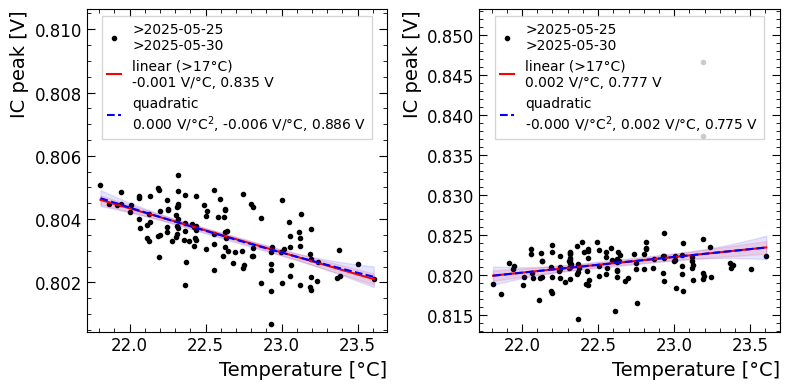

In [28]:
fig, axes = plt.subplots(figsize=(4*2, 4), ncols=2, layout='tight')

# recalibrate straight from purities
# you need to choose a stable lifetime period
LowDate = datetime.datetime(2025, 5, 25)
HighDate = datetime.datetime(2025, 5, 30)
Mask = (PurityData['Date'] > LowDate) & (PurityData['Date'] < HighDate)

LinearCalibration = []
QuadraticCalibration = []

CHANNELS = ['LongIC', 'ShortIC']

for i, ax in enumerate(axes):

        # scatter
        ax.scatter(PurityData[Mask]['T'], PurityData[Mask][CHANNELS[i]], marker = '.', c='black', label=f'>{LowDate.strftime('%Y-%m-%d')}\n>{HighDate.strftime('%Y-%m-%d')}')

        # fits
        x = PurityData[Mask]['T'].values
        y = PurityData[Mask][CHANNELS[i]].values

        ### linear
        # december
        MaskFit = (x < 100)
        # # january
        # MaskFit = (x < 16.5)
        par, cov = scipy.optimize.curve_fit(linear, x[MaskFit], y[MaskFit]); LinearCalibration.append(par)
        domain = numpy.linspace(min(x), max(x), 100)
        ax.plot(domain, linear(domain, *par), c='red', lw=1.5, 
                label=f'linear (>17°C)\n{par[0]:.3f} V/°C, {par[1]:.3f} V')
        err_lin = linear_band(domain, cov)
        ax.fill_between(domain, linear(domain, *par) - err_lin, linear(domain, *par) + err_lin, color='red', alpha=0.1)

        ### poly
        parpoly, covpoly = scipy.optimize.curve_fit(quadratic, x, y); QuadraticCalibration.append(parpoly)
        ax.plot(domain, quadratic(domain, *parpoly), c='blue', lw=1.5, ls='--', 
                label=f'quadratic\n{parpoly[0]:.3f} V/°C$^2$, {parpoly[1]:.3f} V/°C, {parpoly[2]:.3f} V')
        err_lin = quadratic_band(domain, covpoly)
        ax.fill_between(domain, quadratic(domain, *parpoly) - err_lin, quadratic(domain, *parpoly) + err_lin, color='blue', alpha=0.1)

        pmana.utils.plotting.UpdateMatplotlibStyle(ax, f'Temperature [°C]', f'IC peak [V]')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.005)
        ax.legend(loc='upper center', fancybox=False, handlelength=1)

In [169]:
def ApplyCalibration(peak, T, T_ref, par, mode='linear'):

  if mode == 'linear':
    if len(par) != 2:
      raise Exception(f'Cannot apply {mode} calibration with {len(par)} fit parameters.')

    a, b = par
    fT  = a*T  + b
    fT0 = a*T_ref + b

  elif mode == 'quadratic':

    if len(par) != 3:
      raise Exception(f'Cannot apply {mode} calibration with {len(par)} fit parameters.')
    
    a, b, c = par
    fT  = a*T**2  + b*T  + c
    fT0 = a*T_ref**2 + b*T_ref + c

  else:
    raise ValueError(f'Unknown calibration mode: {mode}')
  
  peak_calibrated = peak - (fT - fT0)

  return peak_calibrated

##### Long Bi-PrM

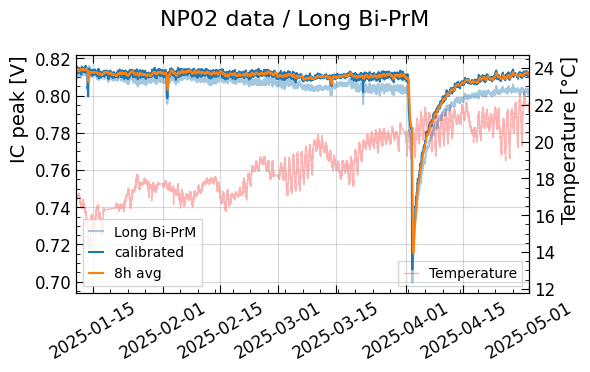

In [30]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 1, 11)
HighDate = datetime.datetime(2025, 5, 1)

### Bi-PrM -- long only here, normalized to asymptotic purity
SCALE_FACTOR = 1
Mask = (PurityData.Date > LowDate) & (PurityData.Date < HighDate)

ax.plot(PurityData[Mask].Date, PurityData[Mask].LongIC, marker='', ls='-', alpha=0.4, c='C0', label='Long Bi-PrM')

### Temperature calibration

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

# calibrated -- you need a T0, pay attention to this
PurityDataMasked = PurityData[Mask].copy()
PurityDataMasked['LongIC_Cal'] = ApplyCalibration(
  PurityDataMasked['LongIC'].values,
  PurityDataMasked['T'].values,
  TEMPERATURE_ASYMPTOTIC_LIFETIME,
  LinearCalibration[0]
)

ax.plot(PurityDataMasked.Date, PurityDataMasked.LongIC_Cal, marker='', ls='-', alpha=1, c='C0', label='calibrated')

PurityDataMasked['LongIC_Cal_Rolling'] = abs(PurityDataMasked.LongIC_Cal).rolling(window=8*1, min_periods=1).mean()
ax.plot(PurityDataMasked.Date, PurityDataMasked.LongIC_Cal_Rolling, marker='', ls='-', alpha=1, c='C1', label='8h avg')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'IC peak [V]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
# ax.set_ylim(0, 45)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='lower right')
# a2.set_ylim(18, 24)

# inset
# axins = ax.inset_axes(
#     [0.1, 0.15, 0.35, 0.45],
#     xlim=(datetime.datetime(2025, 4, 25), datetime.datetime(2025, 4, 30)), ylim=(0.795, 0.815),
#     xticklabels=[], yticklabels=[])
# axins.plot(PurityData[Mask].Date, PurityData[Mask].LongIC * SCALE_FACTOR, marker='', ls='-', alpha=0.4, c='C0', label='uncalibrated')
# axins.plot(PurityDataMasked.Date, PurityDataMasked.LongIC_Cal * SCALE_FACTOR, marker='', ls='-', alpha=1, c='C0', label='calibrated')
# axins.set_xticks([])
# axins.set_yticks([])
# axins2 = axins.twinx()
# axins2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
# axins2.set_yticks([])
# ax.indicate_inset_zoom(axins, edgecolor="black")

fig.suptitle(f'NP02 data / Long Bi-PrM', fontsize=16)

plt.show()

In [31]:
### single-PM purity
def ComputePurity_SinglePM(
        ICPeak,
        AymptoticICPeak,
        Drift = 200, # mm
        DriftVelocity = 1.547 # mm / us
):
        
    ### drift time difference
    DT = (Drift) / DriftVelocity # us

    ### electron lifetime
    Purity = DT / numpy.log(AymptoticICPeak / ICPeak)

    return Purity

### normalize to asymptotic lifetime
LONG_IC_ASYMPTOTIC_LIFETIME = 0.815 # .8146925852420415

PurityDataMasked['Lifetime_LongPM_Normalized'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.LongIC, LONG_IC_ASYMPTOTIC_LIFETIME, 200, 1.547) / 1e3,
    axis=1
)

PurityDataMasked['Lifetime_LongPM_Normalized_Cal'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.LongIC_Cal, LONG_IC_ASYMPTOTIC_LIFETIME, 200, 1.547) / 1e3,
    axis=1
)

PurityDataMasked['Lifetime_LongPM_Normalized_Cal_Rolling'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.LongIC_Cal_Rolling, LONG_IC_ASYMPTOTIC_LIFETIME, 200, 1.547) / 1e3,
    axis=1
)

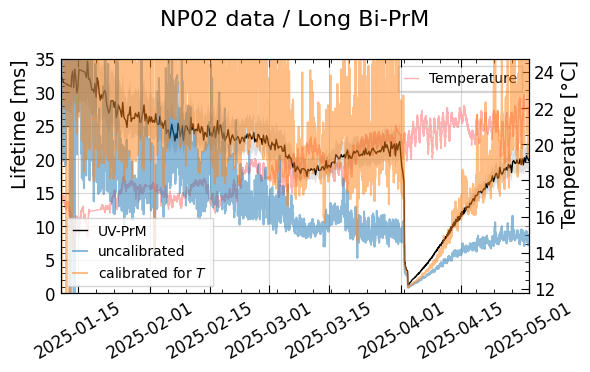

In [32]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 1, 11)
HighDate = datetime.datetime(2025, 5, 1)

# UV-PrM
Mask = (UVData.Date > LowDate) & (UVData.Date < HighDate)
ymin = numpy.minimum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ymax = numpy.maximum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ax.fill_between(UVData[Mask].Date, ymin, ymax, fc='gray', alpha=0.25)
ax.plot(UVData[Mask].Date, UVData[Mask].Center, lw=1, c='black', label='UV-PrM')

# Bi-PrM
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_LongPM_Normalized, marker='', ls='-', alpha=0.5, c='C0', label='uncalibrated')

# Bi-PrM -- temperature calibrated
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_LongPM_Normalized_Cal, marker='', ls='-', alpha=0.5, c='C1', label='calibrated for $T$')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
ax.set_ylim(0, 35)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper right')
# a2.set_ylim(18, 24)

fig.suptitle(f'NP02 data / Long Bi-PrM', fontsize=16)

plt.show()

You cannot average the lifetime.
You have to average the attenuation, and then extract the lifetime.

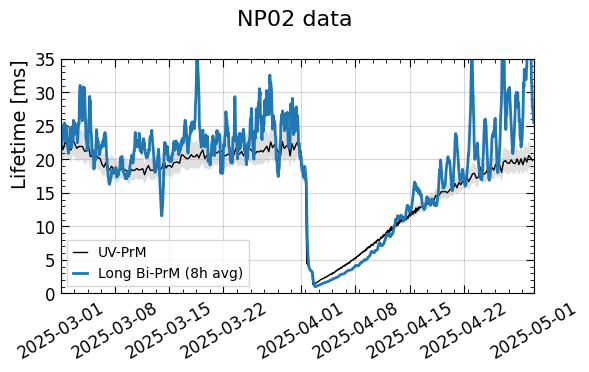

In [46]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 1, 11)
HighDate = datetime.datetime(2025, 5, 1)

# UV-PrM
Mask = (UVData.Date > LowDate) & (UVData.Date < HighDate)
ymin = numpy.minimum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ymax = numpy.maximum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ax.fill_between(UVData[Mask].Date, ymin, ymax, fc='gray', alpha=0.25)
ax.plot(UVData[Mask].Date, UVData[Mask].Center, lw=1, c='black', label='UV-PrM')

# Bi-PrM -- temperature calibrated
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_LongPM_Normalized_Cal_Rolling, lw=2, label='Long Bi-PrM (8h avg)')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
ax.set_ylim(0, 35)
ax.grid(alpha=0.5)

# # temperature
# a2 = ax.twinx()
# a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
# ax.patch.set_visible(False)
# a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
# pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
# a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper right')
# a2.set_ylim(18, 24)

fig.suptitle(f'NP02 data', fontsize=16)
ax.set_xlim(datetime.datetime(2025, 3, 1), datetime.datetime(2025, 5, 1))
# ax.set_xlim(datetime.datetime(2025, 3, 28), datetime.datetime(2025, 4, 6))

plt.show()
fig.savefig('../../plots/cern/NP02_LongBiPrM_UVPrM_April2025.png', dpi=300)

##### Long Bi-PrM (December 2025 - January 2026)

In [110]:
PATH_IC = '/Users/triozzi/Analysis/PurityMonitors/output/ICPeak_Dec_Jan_2026.pkl'

# read data
PurityData = pandas.read_pickle(PATH_IC)

# clean outliers from failed fits
window = 12 # n. of points to roll over
rolling_mean = PurityData.Lifetime.rolling(window, min_periods=1).mean()
MaskOutliers = numpy.abs(PurityData.Lifetime - rolling_mean) < 1

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

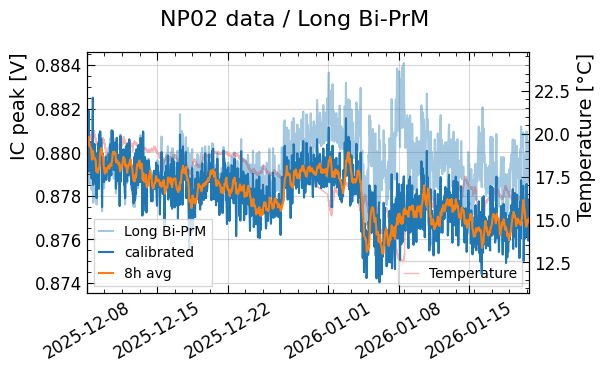

In [112]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 12, 8)
HighDate = datetime.datetime(2026, 1, 21)

### Bi-PrM -- long only here, normalized to asymptotic purity
SCALE_FACTOR = 1
Mask = (PurityData.Date > LowDate) & (PurityData.Date < HighDate)

ax.plot(PurityData[Mask].Date, PurityData[Mask].ShortIC, marker='', ls='-', alpha=0.4, c='C0', label='Long Bi-PrM')

### Temperature calibration

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

# calibrated -- you need a T0, pay attention to this
PurityDataMasked = PurityData[Mask].copy()
PurityDataMasked['ShortIC_Cal'] = ApplyCalibration(
  PurityDataMasked['ShortIC'].values,
  PurityDataMasked['T'].values,
  19.161138161221434,
  LinearCalibration[0]
)

ax.plot(PurityDataMasked.Date, PurityDataMasked.ShortIC_Cal, marker='', ls='-', alpha=1, c='C0', label='calibrated')

PurityDataMasked['ShortIC_Cal_Rolling'] = abs(PurityDataMasked.ShortIC_Cal).rolling(window=8*1, min_periods=1).mean()
ax.plot(PurityDataMasked.Date, PurityDataMasked.ShortIC_Cal_Rolling, marker='', ls='-', alpha=1, c='C1', label='8h avg')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'IC peak [V]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
# ax.set_ylim(0, 45)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='lower right')
# a2.set_ylim(18, 24)

# inset
# axins = ax.inset_axes(
#     [0.1, 0.15, 0.35, 0.45],
#     xlim=(datetime.datetime(2025, 4, 25), datetime.datetime(2025, 4, 30)), ylim=(0.795, 0.815),
#     xticklabels=[], yticklabels=[])
# axins.plot(PurityData[Mask].Date, PurityData[Mask].LongIC * SCALE_FACTOR, marker='', ls='-', alpha=0.4, c='C0', label='uncalibrated')
# axins.plot(PurityDataMasked.Date, PurityDataMasked.LongIC_Cal * SCALE_FACTOR, marker='', ls='-', alpha=1, c='C0', label='calibrated')
# axins.set_xticks([])
# axins.set_yticks([])
# axins2 = axins.twinx()
# axins2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
# axins2.set_yticks([])
# ax.indicate_inset_zoom(axins, edgecolor="black")

fig.suptitle(f'NP02 data / Long Bi-PrM', fontsize=16)

plt.show()

In [125]:
### single-PM purity
def ComputePurity_SinglePM(
        ICPeak,
        AymptoticICPeak,
        Drift = 200, # mm
        DriftVelocity = 1.547 # mm / us
):
        
    ### drift time difference
    DT = (Drift) / DriftVelocity # us

    ### electron lifetime
    Purity = DT / numpy.log(AymptoticICPeak / ICPeak)

    return Purity

### normalize to asymptotic lifetime
LONG_IC_ASYMPTOTIC_LIFETIME = 0.883 #0.8799026343264879

PurityDataMasked['Lifetime_LongPM_Normalized'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.ShortIC, LONG_IC_ASYMPTOTIC_LIFETIME, 200, 1.547) / 1e3,
    axis=1
)

PurityDataMasked['Lifetime_LongPM_Normalized_Cal'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.ShortIC_Cal, LONG_IC_ASYMPTOTIC_LIFETIME, 200, 1.547) / 1e3,
    axis=1
)

PurityDataMasked['Lifetime_LongPM_Normalized_Cal_Rolling'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.ShortIC_Cal_Rolling, LONG_IC_ASYMPTOTIC_LIFETIME, 200, 1.547) / 1e3,
    axis=1
)

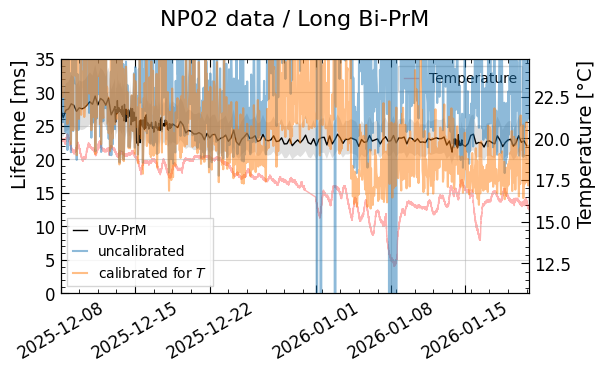

In [126]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 12, 8)
HighDate = datetime.datetime(2026, 1, 21)

# UV-PrM
Mask = (UVData.Date > LowDate) & (UVData.Date < HighDate)
ymin = numpy.minimum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ymax = numpy.maximum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ax.fill_between(UVData[Mask].Date, ymin, ymax, fc='gray', alpha=0.25)
ax.plot(UVData[Mask].Date, UVData[Mask].Center, lw=1, c='black', label='UV-PrM')

# Bi-PrM
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_LongPM_Normalized, marker='', ls='-', alpha=0.5, c='C0', label='uncalibrated')

# Bi-PrM -- temperature calibrated
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_LongPM_Normalized_Cal, marker='', ls='-', alpha=0.5, c='C1', label='calibrated for $T$')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
ax.set_ylim(0, 35)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper right')
# a2.set_ylim(18, 24)

fig.suptitle(f'NP02 data / Long Bi-PrM', fontsize=16)

plt.show()

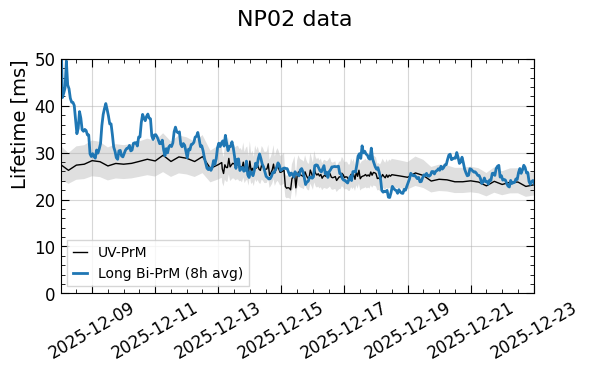

In [135]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 12, 8)
HighDate = datetime.datetime(2026, 1, 31)

# UV-PrM
Mask = (UVData.Date > LowDate) & (UVData.Date < HighDate)
ymin = numpy.minimum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ymax = numpy.maximum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ax.fill_between(UVData[Mask].Date, ymin, ymax, fc='gray', alpha=0.25)
ax.plot(UVData[Mask].Date, UVData[Mask].Center, lw=1, c='black', label='UV-PrM')

# Bi-PrM -- temperature calibrated
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_LongPM_Normalized_Cal_Rolling, lw=2, label='Long Bi-PrM (8h avg)')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
ax.set_ylim(0, 50)
ax.grid(alpha=0.5)

# # temperature
# a2 = ax.twinx()
# a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
# ax.patch.set_visible(False)
# a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
# pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
# a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper right')
# a2.set_ylim(18, 24)

fig.suptitle(f'NP02 data', fontsize=16)
ax.set_xlim(datetime.datetime(2025, 12, 8), datetime.datetime(2025, 12, 23))

plt.show()
fig.savefig('../../plots/cern/NP02_LongBiPrM_UVPrM_December2025.png', dpi=300)

##### Short Bi-PrM

The Short-PrM is veru jumpy. Filter stuff.

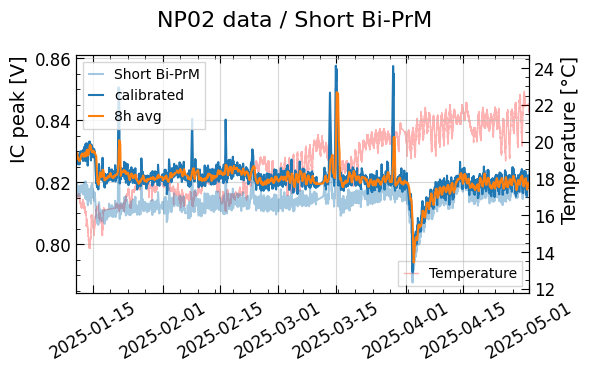

In [92]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 1, 11)
HighDate = datetime.datetime(2025, 5, 1)

### Bi-PrM -- short only here
SCALE_FACTOR = 1
Mask = (PurityData.Date > LowDate) & (PurityData.Date < HighDate)

# clean data -- short Bi-PrM can be messy
rolling_med = PurityData.ShortIC.rolling(12, center=True).median()
residuals = PurityData.ShortIC - rolling_med
MAD = numpy.nanmedian(numpy.abs(residuals - numpy.nanmedian(residuals)))
MaskClean = numpy.abs(residuals) < 3.0 * MAD

ax.plot(PurityData[Mask & MaskClean].Date, PurityData[Mask & MaskClean].ShortIC, marker='', ls='-', alpha=0.4, c='C0', label='Short Bi-PrM')

### Temperature calibration

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

# calibrated -- you need a T0, pay attention to this
# PurityDataMasked = PurityData[Mask & MaskClean].copy() ###< you should have already made this from before...
PurityDataMasked['ShortIC_Cal'] = ApplyCalibration(
  PurityDataMasked['ShortIC'].values,
  PurityDataMasked['T'].values,
  SHORT_TEMPERATURE_ASYMPTOTIC_LIFETIME,
  LinearCalibration[1]
)

# clean data - on the masked side
rolling_med = PurityDataMasked.ShortIC.rolling(12, center=True).median()
residuals = PurityDataMasked.ShortIC - rolling_med
MAD = numpy.nanmedian(numpy.abs(residuals - numpy.nanmedian(residuals)))
MaskCleanShortPeak =  numpy.abs(residuals) < 3 * MAD

ax.plot(PurityDataMasked[MaskCleanShortPeak].Date, PurityDataMasked[MaskCleanShortPeak].ShortIC_Cal, marker='', ls='-', alpha=1, c='C0', label='calibrated')

PurityDataMasked['ShortIC_Cal_Rolling'] = abs(PurityDataMasked[MaskCleanShortPeak].ShortIC_Cal).rolling(window=8*1, min_periods=1).mean()
ax.plot(PurityDataMasked[MaskCleanShortPeak].Date, PurityDataMasked[MaskCleanShortPeak].ShortIC_Cal_Rolling, marker='', ls='-', alpha=1, c='C1', label='8h avg')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'IC peak [V]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='upper left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
# ax.set_ylim(0, 45)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='lower right')
# a2.set_ylim(18, 24)

fig.suptitle(f'NP02 data / Short Bi-PrM', fontsize=16)

plt.show()

In [93]:
### single-PM purity
def ComputePurity_SinglePM(
        ICPeak,
        AymptoticICPeak,
        Drift = 200, # mm
        DriftVelocity = 1.547 # mm / us
):
        
    ### drift time difference
    DT = (Drift) / DriftVelocity # us

    ### electron lifetime
    Purity = DT / numpy.log(AymptoticICPeak / ICPeak)

    return Purity

### normalize to asymptotic lifetime
SHORT_IC_ASYMPTOTIC_LIFETIME = 0.8220973348280766

PurityDataMasked['Lifetime_ShortPM_Normalized'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.ShortIC, SHORT_IC_ASYMPTOTIC_LIFETIME, 40, 1.547) / 1e3,
    axis=1
)

PurityDataMasked['Lifetime_ShortPM_Normalized_Cal'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.ShortIC_Cal, SHORT_IC_ASYMPTOTIC_LIFETIME, 40, 1.547) / 1e3,
    axis=1
)

PurityDataMasked['Lifetime_ShortPM_Normalized_Cal_Rolling'] = PurityDataMasked.apply(
    lambda x: ComputePurity_SinglePM(x.ShortIC_Cal_Rolling, SHORT_IC_ASYMPTOTIC_LIFETIME, 40, 1.547) / 1e3,
    axis=1
)

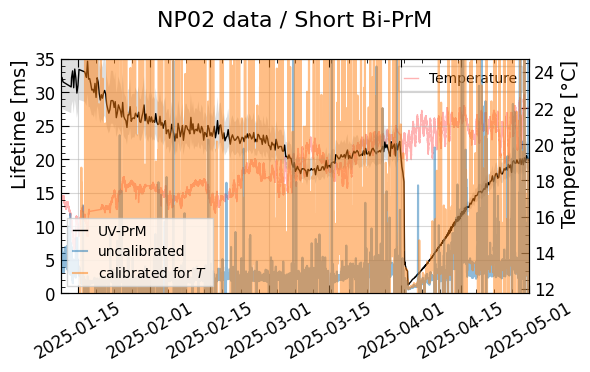

In [94]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 1, 11)
HighDate = datetime.datetime(2025, 5, 1)

# UV-PrM
Mask = (UVData.Date > LowDate) & (UVData.Date < HighDate)
ymin = numpy.minimum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ymax = numpy.maximum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ax.fill_between(UVData[Mask].Date, ymin, ymax, fc='gray', alpha=0.25)
ax.plot(UVData[Mask].Date, UVData[Mask].Center, lw=1, c='black', label='UV-PrM')

# Bi-PrM
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_ShortPM_Normalized, marker='', ls='-', alpha=0.5, c='C0', label='uncalibrated')

# Bi-PrM -- temperature calibrated
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_ShortPM_Normalized_Cal, marker='', ls='-', alpha=0.5, c='C1', label='calibrated for $T$')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
ax.set_ylim(0, 35)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper right')
# a2.set_ylim(18, 24)

fig.suptitle(f'NP02 data / Short Bi-PrM', fontsize=16)

plt.show()

Again, average the attenuation.

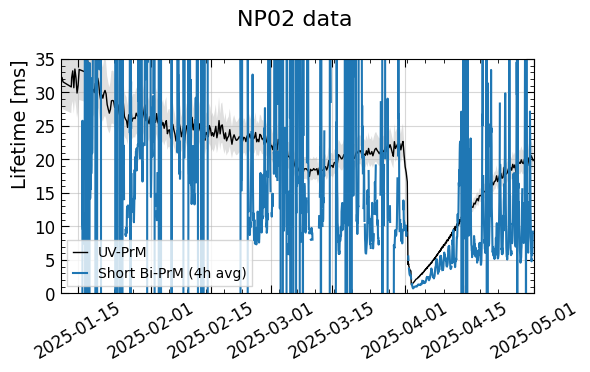

In [95]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 1, 11)
HighDate = datetime.datetime(2025, 5, 1)

# UV-PrM
Mask = (UVData.Date > LowDate) & (UVData.Date < HighDate)
ymin = numpy.minimum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ymax = numpy.maximum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ax.fill_between(UVData[Mask].Date, ymin, ymax, fc='gray', alpha=0.25)
ax.plot(UVData[Mask].Date, UVData[Mask].Center, lw=1, c='black', label='UV-PrM')

# Bi-PrM -- temperature calibrated
# ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_LongPM_Normalized_Cal, marker='', ls='-', alpha=0.5, c='C1', label='calibrated for $T$')
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_ShortPM_Normalized_Cal_Rolling, label='Short Bi-PrM (4h avg)')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
ax.set_ylim(0, 35)
ax.grid(alpha=0.5)

# # temperature
# a2 = ax.twinx()
# a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
# ax.patch.set_visible(False)
# a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
# pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
# a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper right')
# a2.set_ylim(18, 24)

fig.suptitle(f'NP02 data', fontsize=16)
# ax.set_xlim(datetime.datetime(2025, 3, 27), datetime.datetime(2025, 4, 9))

plt.show()

##### Double Bi-PrM

Make sure to scale by the ratio of the correction at the two different temperatures.
The IC peaks are calibrated at different temperatures.

In [96]:
### double Bi-PrM purity -- make sure to look at calibrated stuff
def ComputePurity(
        Short,
        Long,
        ShortDrift = 40, # mm
        LongDrift = 200, # mm
        DriftVelocity = 1.547 # mm / us
):
        
    ### drift time difference
    DT = (ShortDrift - LongDrift) / DriftVelocity # us

    ### electron lifetime
    Purity = DT / numpy.log(Long / Short)

    return Purity


PurityDataMasked['Lifetime_DoublePM'] = PurityDataMasked.apply(
    lambda x: ComputePurity(x.ShortIC, x.LongIC, 40, 200, 1.547) / 1e3,
    axis=1
)

PurityDataMasked['Lifetime_DoublePM_Cal'] = PurityDataMasked.apply(
    lambda x: ComputePurity(abs(x.ShortIC_Cal), abs(x.LongIC_Cal), 40, 200, 1.547) / 1e3,
    axis=1
)

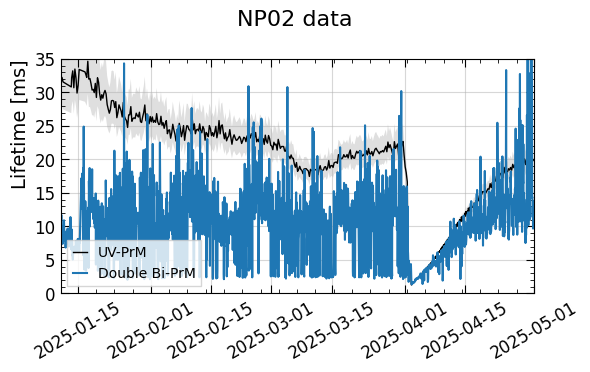

In [97]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 1, 11)
HighDate = datetime.datetime(2025, 5, 1)

# UV-PrM
Mask = (UVData.Date > LowDate) & (UVData.Date < HighDate)
ymin = numpy.minimum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ymax = numpy.maximum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ax.fill_between(UVData[Mask].Date, ymin, ymax, fc='gray', alpha=0.25)
ax.plot(UVData[Mask].Date, UVData[Mask].Center, lw=1, c='black', label='UV-PrM')

# Bi-PrM -- temperature calibrated
SCALE_FACTOR = SHORT_TEMPERATURE_ASYMPTOTIC_LIFETIME / TEMPERATURE_ASYMPTOTIC_LIFETIME
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_DoublePM_Cal * SCALE_FACTOR, marker='', ls='-', c='C0', label='Double Bi-PrM')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='lower left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
ax.set_ylim(0, 35)
ax.grid(alpha=0.5)

# # temperature
# a2 = ax.twinx()
# a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
# ax.patch.set_visible(False)
# a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
# pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
# a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper right')
# a2.set_ylim(18, 24)

fig.suptitle(f'NP02 data', fontsize=16)

# ax.set_xlim(datetime.datetime(2025, 3, 27), datetime.datetime(2025, 4, 9))

plt.show()

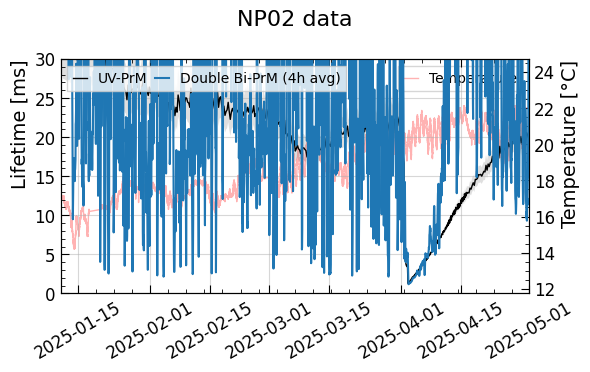

In [91]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

LowDate = datetime.datetime(2025, 1, 11)
HighDate = datetime.datetime(2025, 5, 1)

# UV-PrM
Mask = (UVData.Date > LowDate) & (UVData.Date < HighDate)
ymin = numpy.minimum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ymax = numpy.maximum.reduce([UVData[Mask].Low, UVData[Mask].Center, UVData[Mask].High])
ax.fill_between(UVData[Mask].Date, ymin, ymax, fc='gray', alpha=0.25)
ax.plot(UVData[Mask].Date, UVData[Mask].Center, lw=1, c='black', label='UV-PrM')

# Bi-PrM
SCALE_FACTOR = 1
Mask = (PurityData.Date > LowDate) & (PurityData.Date < HighDate)
# ax.scatter(PurityData[MaskOutliers].Date, abs(PurityData[MaskOutliers].Lifetime*6), marker='.', alpha=1, c='black')
PurityDataMasked['Lifetime_Rolling'] = abs(PurityDataMasked.Lifetime_DoublePM_Cal).rolling(window=4*1, min_periods=1).mean()
ax.plot(PurityDataMasked.Date, PurityDataMasked.Lifetime_Rolling * SCALE_FACTOR, marker='', ls='-', alpha=1, c='C0', label='Double Bi-PrM (4h avg)')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Lifetime [ms]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=3, fontsize=10, loc='upper left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
ax.set_ylim(0, 30)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='upper right')
# a2.set_ylim(18, 24)

# a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='lower right')
# # lines
# ax.axhline(3, c='black', zorder=-1)
# ax.axhline(20, c='black', zorder=-1)

fig.suptitle(f'NP02 data', fontsize=16)

plt.show()

#### Electronics performance from IC peaks (November)

In [166]:
PATH_IC = '/Users/triozzi/Analysis/PurityMonitors/output/Purity_Jan_May.pkl'

# read data
PurityData = pandas.read_pickle(PATH_IC)
PurityData.Lifetime = PurityData.Lifetime / 1e3
PurityData.Lifetime_LongPM_Normalized = PurityData.Lifetime_LongPM_Normalized / 1e3
PurityData.Lifetime_ShortPM_Normalized = PurityData.Lifetime_ShortPM_Normalized / 1e3

# clean outliers from failed fits
window = 12 # n. of points to roll over
rolling_mean = PurityData.Lifetime.rolling(window, min_periods=1).mean()
MaskOutliers = numpy.abs(PurityData.Lifetime - rolling_mean) < 1

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

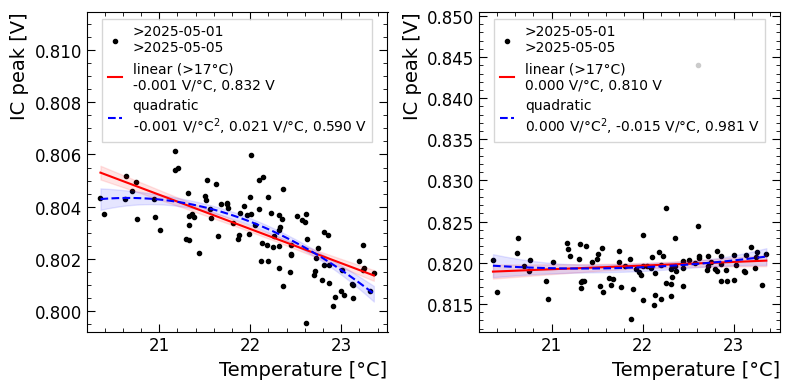

In [167]:
fig, axes = plt.subplots(figsize=(4*2, 4), ncols=2, layout='tight')

# january
LowDate = datetime.datetime(2025, 5, 1)
HighDate = datetime.datetime(2025, 5, 5)
Mask = (PurityData['Date'] > LowDate) & (PurityData['Date'] < HighDate)

LinearCalibration = []
QuadraticCalibration = []

CHANNELS = ['LongIC', 'ShortIC']

for i, ax in enumerate(axes):

        # scatter
        ax.scatter(PurityData[Mask]['T'], PurityData[Mask][CHANNELS[i]], marker = '.', c='black', label=f'>{LowDate.strftime('%Y-%m-%d')}\n>{HighDate.strftime('%Y-%m-%d')}')

        # fits
        x = PurityData[Mask]['T'].values
        y = PurityData[Mask][CHANNELS[i]].values

        ### linear
        # december
        MaskFit = (x < 100)
        # # january
        # MaskFit = (x < 16.5)
        par, cov = scipy.optimize.curve_fit(linear, x[MaskFit], y[MaskFit]); LinearCalibration.append(par)
        domain = numpy.linspace(min(x), max(x), 100)
        ax.plot(domain, linear(domain, *par), c='red', lw=1.5, 
                label=f'linear (>17°C)\n{par[0]:.3f} V/°C, {par[1]:.3f} V')
        err_lin = linear_band(domain, cov)
        ax.fill_between(domain, linear(domain, *par) - err_lin, linear(domain, *par) + err_lin, color='red', alpha=0.1)

        ### poly
        parpoly, covpoly = scipy.optimize.curve_fit(quadratic, x, y); QuadraticCalibration.append(parpoly)
        ax.plot(domain, quadratic(domain, *parpoly), c='blue', lw=1.5, ls='--', 
                label=f'quadratic\n{parpoly[0]:.3f} V/°C$^2$, {parpoly[1]:.3f} V/°C, {parpoly[2]:.3f} V')
        err_lin = quadratic_band(domain, covpoly)
        ax.fill_between(domain, quadratic(domain, *parpoly) - err_lin, quadratic(domain, *parpoly) + err_lin, color='blue', alpha=0.1)

        pmana.utils.plotting.UpdateMatplotlibStyle(ax, f'Temperature [°C]', f'IC peak [V]')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.005)
        ax.legend(loc='upper center', fancybox=False, handlelength=1)

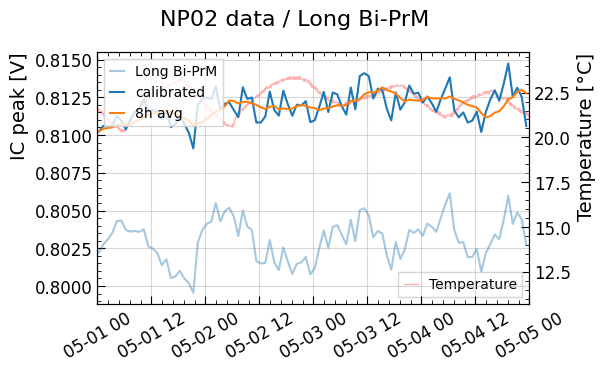

In [170]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

# january
LowDate = datetime.datetime(2025, 5, 1)
HighDate = datetime.datetime(2025, 5, 5)
Mask = (PurityData['Date'] > LowDate) & (PurityData['Date'] < HighDate)

### Bi-PrM -- long only here, normalized to asymptotic purity
SCALE_FACTOR = 1
Mask = (PurityData.Date > LowDate) & (PurityData.Date < HighDate)

ax.plot(PurityData[Mask].Date, PurityData[Mask].LongIC, marker='', ls='-', alpha=0.4, c='C0', label='Long Bi-PrM')

### Temperature calibration

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

# calibrated -- you need a T0, pay attention to this
PurityDataMasked = PurityData[Mask].copy()
PurityDataMasked['LongIC_Cal'] = ApplyCalibration(
  PurityDataMasked['LongIC'].values,
  PurityDataMasked['T'].values,
  TEMPERATURE_ASYMPTOTIC_LIFETIME,
  LinearCalibration[0]
)

ax.plot(PurityDataMasked.Date, PurityDataMasked.LongIC_Cal, marker='', ls='-', alpha=1, c='C0', label='calibrated')

PurityDataMasked['LongIC_Cal_Rolling'] = abs(PurityDataMasked.LongIC_Cal).rolling(window=8*1, min_periods=1).mean()
ax.plot(PurityDataMasked.Date, PurityDataMasked.LongIC_Cal_Rolling, marker='', ls='-', alpha=1, c='C1', label='8h avg')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'IC peak [V]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='upper left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
# ax.set_ylim(0, 45)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='lower right')
# a2.set_ylim(18, 24)

# inset
# axins = ax.inset_axes(
#     [0.1, 0.15, 0.35, 0.45],
#     xlim=(datetime.datetime(2025, 4, 25), datetime.datetime(2025, 4, 30)), ylim=(0.795, 0.815),
#     xticklabels=[], yticklabels=[])
# axins.plot(PurityData[Mask].Date, PurityData[Mask].LongIC * SCALE_FACTOR, marker='', ls='-', alpha=0.4, c='C0', label='uncalibrated')
# axins.plot(PurityDataMasked.Date, PurityDataMasked.LongIC_Cal * SCALE_FACTOR, marker='', ls='-', alpha=1, c='C0', label='calibrated')
# axins.set_xticks([])
# axins.set_yticks([])
# axins2 = axins.twinx()
# axins2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
# axins2.set_yticks([])
# ax.indicate_inset_zoom(axins, edgecolor="black")

fig.suptitle(f'NP02 data / Long Bi-PrM', fontsize=16)

plt.show()

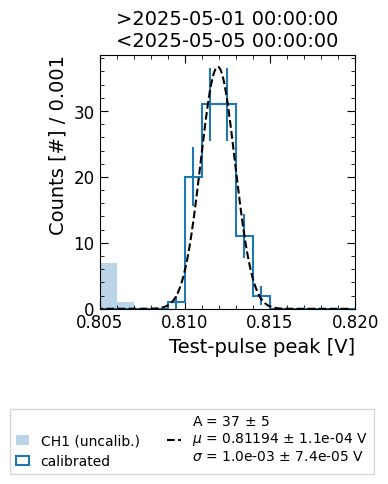

In [114]:
fig, ax = plt.subplots(figsize=(3.3, 3.3))

width = 0.001; binning = numpy.arange(0.805, 0.82+width, width)

# CH1
ax.hist(PurityDataMasked.LongIC, bins=binning, histtype='stepfilled', fc='C0', alpha=0.3, label='CH1 (uncalib.)')

# CH1 -- calibrated
counts, edges, _ = ax.hist(PurityDataMasked.LongIC_Cal, bins=binning, histtype='step', linewidth=1.5, color='C0', label='calibrated')
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C0', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(PurityDataMasked.LongIC_Cal), numpy.std(PurityDataMasked.LongIC_Cal)]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(min(PurityDataMasked.LongIC_Cal)-0.005, max(PurityDataMasked.LongIC_Cal)+0.005, 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=1.5, ls='--', c='black',
        label = f'A = {par[0]:.0f} $\\pm$ {err[0]:.0f}\n$\\mu$ = {par[1]:.5f} $\\pm$ {err[1]:.1e} V\n$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Test-pulse peak [V]', f'Counts [#] / {width}')
ax.legend(loc=(-0.35, -0.65), handlelength=1, ncol=2, fancybox=False)
ax.set_xlim(binning[0], binning[-1])
ax.set_title(f'>{LowDate}\n<{HighDate}', fontsize=14)

plt.show()

In [172]:
### only run this with November data
NOVEMBER_IC_PEAK_LONG = PurityDataMasked.LongIC_Cal

#### Electronics performance from IC peaks (January)

In [173]:
PATH_IC = '/Users/triozzi/Analysis/PurityMonitors/output/ICPeak_Dec_Jan_2026.pkl'

# read data
PurityData = pandas.read_pickle(PATH_IC)

# clean outliers from failed fits
window = 12 # n. of points to roll over
rolling_mean = PurityData.Lifetime.rolling(window, min_periods=1).mean()
MaskOutliers = numpy.abs(PurityData.Lifetime - rolling_mean) < 1

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

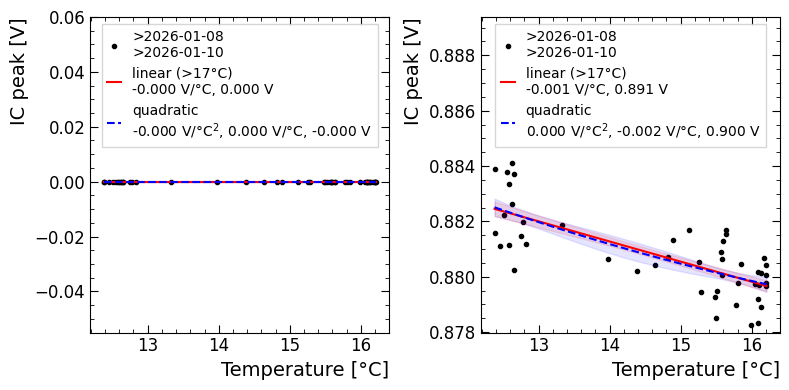

In [174]:
fig, axes = plt.subplots(figsize=(4*2, 4), ncols=2, layout='tight')

# january
LowDate = datetime.datetime(2026, 1, 8)
HighDate = datetime.datetime(2026, 1, 10)
Mask = (PurityData['Date'] > LowDate) & (PurityData['Date'] < HighDate)

LinearCalibration = []
QuadraticCalibration = []

CHANNELS = ['LongIC', 'ShortIC']

for i, ax in enumerate(axes):

        # scatter
        ax.scatter(PurityData[Mask]['T'], PurityData[Mask][CHANNELS[i]], marker = '.', c='black', label=f'>{LowDate.strftime('%Y-%m-%d')}\n>{HighDate.strftime('%Y-%m-%d')}')

        # fits
        x = PurityData[Mask]['T'].values
        y = PurityData[Mask][CHANNELS[i]].values

        ### linear
        # december
        MaskFit = (x < 100)
        # # january
        # MaskFit = (x < 16.5)
        par, cov = scipy.optimize.curve_fit(linear, x[MaskFit], y[MaskFit]); LinearCalibration.append(par)
        domain = numpy.linspace(min(x), max(x), 100)
        ax.plot(domain, linear(domain, *par), c='red', lw=1.5, 
                label=f'linear (>17°C)\n{par[0]:.3f} V/°C, {par[1]:.3f} V')
        err_lin = linear_band(domain, cov)
        ax.fill_between(domain, linear(domain, *par) - err_lin, linear(domain, *par) + err_lin, color='red', alpha=0.1)

        ### poly
        parpoly, covpoly = scipy.optimize.curve_fit(quadratic, x, y); QuadraticCalibration.append(parpoly)
        ax.plot(domain, quadratic(domain, *parpoly), c='blue', lw=1.5, ls='--', 
                label=f'quadratic\n{parpoly[0]:.3f} V/°C$^2$, {parpoly[1]:.3f} V/°C, {parpoly[2]:.3f} V')
        err_lin = quadratic_band(domain, covpoly)
        ax.fill_between(domain, quadratic(domain, *parpoly) - err_lin, quadratic(domain, *parpoly) + err_lin, color='blue', alpha=0.1)

        pmana.utils.plotting.UpdateMatplotlibStyle(ax, f'Temperature [°C]', f'IC peak [V]')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.005)
        ax.legend(loc='upper center', fancybox=False, handlelength=1)

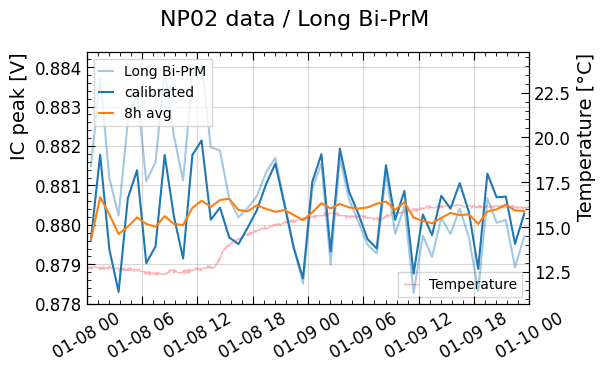

In [175]:
fig, ax = plt.subplots(figsize=(6, 3.75*1), nrows=1, layout='tight')

# january
LowDate = datetime.datetime(2026, 1, 8)
HighDate = datetime.datetime(2026, 1, 10)
Mask = (PurityData['Date'] > LowDate) & (PurityData['Date'] < HighDate)

### Bi-PrM -- long only here, normalized to asymptotic purity
SCALE_FACTOR = 1
Mask = (PurityData.Date > LowDate) & (PurityData.Date < HighDate)

ax.plot(PurityData[Mask].Date, PurityData[Mask].ShortIC, marker='', ls='-', alpha=0.4, c='C0', label='Long Bi-PrM')

### Temperature calibration

# add spline temperature
PurityData['Date_s'] = PurityData["Date"].astype("int64") / 1e9
PurityData['T'] = TempVsTime(PurityData['Date_s'])

# calibrated -- you need a T0, pay attention to this
PurityDataMasked = PurityData[Mask].copy()
PurityDataMasked['ShortIC_Cal'] = ApplyCalibration(
  PurityDataMasked['ShortIC'].values,
  PurityDataMasked['T'].values,
  TEMPERATURE_ASYMPTOTIC_LIFETIME,
  LinearCalibration[1]
)

ax.plot(PurityDataMasked.Date, PurityDataMasked.ShortIC_Cal, marker='', ls='-', alpha=1, c='C0', label='calibrated')

PurityDataMasked['ShortIC_Cal_Rolling'] = abs(PurityDataMasked.ShortIC_Cal).rolling(window=8*1, min_periods=1).mean()
ax.plot(PurityDataMasked.Date, PurityDataMasked.ShortIC_Cal_Rolling, marker='', ls='-', alpha=1, c='C1', label='8h avg')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'IC peak [V]')
ax.legend(frameon=True, fancybox=False, handlelength=1, columnspacing=0.5, ncol=1, fontsize=10, loc='upper left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(LowDate, HighDate)
# ax.set_ylim(0, 45)
ax.grid(alpha=0.5)

# temperature
a2 = ax.twinx()
a2.set_zorder(ax.get_zorder() - 1) # this goes on the background
ax.patch.set_visible(False)
a2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'Temperature [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=10, loc='lower right')
# a2.set_ylim(18, 24)

# inset
# axins = ax.inset_axes(
#     [0.1, 0.15, 0.35, 0.45],
#     xlim=(datetime.datetime(2025, 4, 25), datetime.datetime(2025, 4, 30)), ylim=(0.795, 0.815),
#     xticklabels=[], yticklabels=[])
# axins.plot(PurityData[Mask].Date, PurityData[Mask].LongIC * SCALE_FACTOR, marker='', ls='-', alpha=0.4, c='C0', label='uncalibrated')
# axins.plot(PurityDataMasked.Date, PurityDataMasked.LongIC_Cal * SCALE_FACTOR, marker='', ls='-', alpha=1, c='C0', label='calibrated')
# axins.set_xticks([])
# axins.set_yticks([])
# axins2 = axins.twinx()
# axins2.plot(Temperatures['Date'], Temperatures['T'], lw=1, c='red', alpha=0.3, label='Temperature')
# axins2.set_yticks([])
# ax.indicate_inset_zoom(axins, edgecolor="black")

fig.suptitle(f'NP02 data / Long Bi-PrM', fontsize=16)

plt.show()

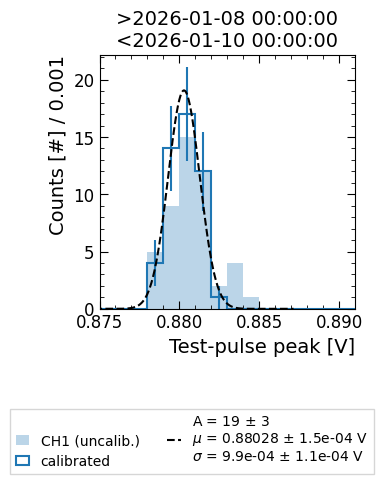

In [176]:
fig, ax = plt.subplots(figsize=(3.3, 3.3))

width = 0.001; binning = numpy.arange(0.875, 0.89+width, width)

# CH1
ax.hist(PurityDataMasked.ShortIC, bins=binning, histtype='stepfilled', fc='C0', alpha=0.3, label='CH1 (uncalib.)')

# CH1 -- calibrated
counts, edges, _ = ax.hist(PurityDataMasked.ShortIC_Cal, bins=binning, histtype='step', linewidth=1.5, color='C0', label='calibrated')
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C0', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(PurityDataMasked.ShortIC_Cal), numpy.std(PurityDataMasked.ShortIC_Cal)]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(min(PurityDataMasked.ShortIC_Cal)-0.005, max(PurityDataMasked.ShortIC_Cal)+0.005, 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=1.5, ls='--', c='black',
        label = f'A = {par[0]:.0f} $\\pm$ {err[0]:.0f}\n$\\mu$ = {par[1]:.5f} $\\pm$ {err[1]:.1e} V\n$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')

# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Test-pulse peak [V]', f'Counts [#] / {width}')
ax.legend(loc=(-0.35, -0.65), handlelength=1, ncol=2, fancybox=False)
ax.set_xlim(binning[0], binning[-1])
ax.set_title(f'>{LowDate}\n<{HighDate}', fontsize=14)

plt.show()

In [177]:
### only run this with November data
JANUARY_IC_PEAK_LONG = PurityDataMasked.ShortIC_Cal

#### Comparison pre- and post-hardware intervention

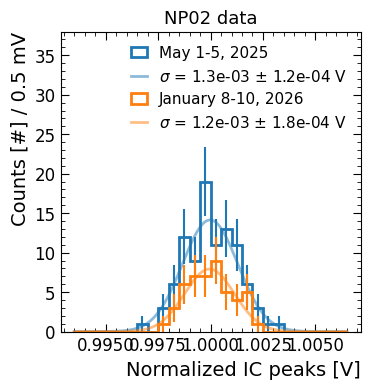

In [201]:
### comparison
fig, ax = plt.subplots(figsize=(4, 4))

plt.subplots_adjust(
    left=0.2,
    right=0.95,
    bottom=0.15,
    top=0.9
)

width = 0.0005; binning = numpy.arange(0.9935, 1.0065+width, width)

### November
counts, edges, _ = ax.hist(NOVEMBER_IC_PEAK_LONG / numpy.mean(NOVEMBER_IC_PEAK_LONG), bins = binning, color='C0', histtype='step', linewidth=2, label='May 1-5, 2025', density=False)
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C0', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(NOVEMBER_IC_PEAK_LONG / numpy.mean(NOVEMBER_IC_PEAK_LONG)), numpy.std(NOVEMBER_IC_PEAK_LONG / numpy.mean(NOVEMBER_IC_PEAK_LONG))]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(binning[0], binning[-1], 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=2, ls='-', c='C0', alpha=0.5, 
        label = f'$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')

### January
counts, edges, _ = ax.hist(JANUARY_IC_PEAK_LONG / numpy.mean(JANUARY_IC_PEAK_LONG), bins=binning, histtype='step', color='C1', linewidth=2, label='January 8-10, 2026', density=False)
x = 0.5 * (edges[:-1] + edges[1:])
ax.errorbar(x, counts, yerr=numpy.sqrt(counts), c='C1', marker='', ls='')

# fit
p0 = [max(counts), numpy.mean(JANUARY_IC_PEAK_LONG / numpy.mean(JANUARY_IC_PEAK_LONG)), numpy.std(JANUARY_IC_PEAK_LONG / numpy.mean(JANUARY_IC_PEAK_LONG))]
par, cov = scipy.optimize.curve_fit(
  pmana.utils.fitting.Gaus, 
  x[counts > 0], counts[counts > 0], 
  p0=p0, 
  sigma=numpy.sqrt(counts[counts > 0]), absolute_sigma=True
)
err = numpy.sqrt(numpy.diag(cov))
dom = numpy.linspace(binning[0], binning[-1], 1000)
ax.plot(dom, pmana.utils.fitting.Gaus(dom, *par), lw=2, ls='-', c='C1', alpha=0.5, 
        label = f'$\\sigma$ = {par[2]:.1e} $\\pm$ {err[2]:.1e} V')


# gfx
pmana.utils.plotting.UpdateMatplotlibStyle(ax, 'Normalized IC peaks [V]', f'Counts [#] / 0.5 mV')
ax.legend(fontsize=11, handlelength=1, frameon=False, loc='upper right')
ax.set_title(f"NP02 data", fontsize=13)

# tweaks
ax.set_ylim(0, 38)

fig.savefig('../../plots/review/ICPeakChange.pdf')

#### Test-pulse across all campaigns

In [ ]:
PATH_TEMPERATURES = f"../../data/cern/NP02_Oct_Jan.csv"

In [68]:
# get temperature mapping
Temperatures = pmana.utils.io.ExtractTemperatureMonitoring(
    PATH_TEMPERATURES,
    IsPadova = False,
    delimiter = "\t",
    skiprows = 1,
    # usecols = [0, 1],
    names = ["Date", "T"]
)

# some more formatting...
Temperatures['Date'] = pandas.to_datetime(
    Temperatures['Date'],
    unit='ms',
    utc=True
)
Temperatures = Temperatures.drop_duplicates()

In [24]:
TIME_DIRS = {
  "2025_Dec" : [2025, 12],
  "2026_Jan" : [2026, 1]
}

In [25]:
AggregatedOutput = pandas.DataFrame()

for DIR in TIME_DIRS:
  PATH_CAMPAIGN = f"../../data/cern/{DIR}"
  print(f"Analyizing {PATH_CAMPAIGN}...")

  # analyze campaign
  Output = pmana.utils.anatestdata.IterateCERN(
      PATH_CAMPAIGN,  ###< path to data
      # pmana.utils.anatestdata.AnalyzeMeasurement, 
      functools.partial(
          pmana.utils.anatestdata.GaussianFitToChannel, 
          IS_DT5781=False, rebin=False, debug=False,
          MASK_TESTPULSE = True, DELIMITER = ',', SKIP_NROWS = 4, 
          BINNAME = 'BinCenter', COUNTNAME = 'Population'
      ),  ###< analyzing module, changing some options 
      YEAR = TIME_DIRS[DIR][0],
      MONTH = TIME_DIRS[DIR][1]
  )

  # convert top DataFrame
  Output = pandas.DataFrame(Output)

  AggregatedOutput = pandas.concat((AggregatedOutput, Output))

Analyizing ../../data/cern/2025_Dec...
Analyizing ../../data/cern/2026_Jan...


In [26]:
# re-format the dataframe
AggregatedOutput.columns = ["Peak_CH1", "Err_Peak_CH1", "Width_CH1", "Err_Width_CH1",
                  "Peak_CH2", "Err_Peak_CH2", "Width_CH2", "Err_Width_CH2", 
                  "Peak_CH3", "Err_Peak_CH3", "Width_CH3", "Err_Width_CH3", 
                  "Date"]

# sort by date
AggregatedOutput.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

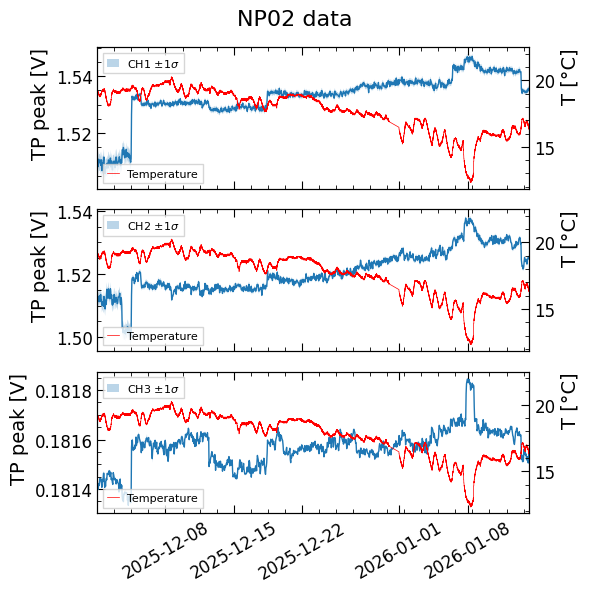

In [27]:
fig, ax = plt.subplots(figsize=(6, 2.*3), nrows=3, layout='tight')

# CH1
pmana.utils.plotting.PlotTimeSeriesWithErrors(ax[0], AggregatedOutput.Date, AggregatedOutput.Peak_CH1, AggregatedOutput.Err_Peak_CH1, LABEL='CH1 $\\pm1\\sigma$', XLABELS=False)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'TP peak [V]')

# CH2
pmana.utils.plotting.PlotTimeSeriesWithErrors(ax[1], AggregatedOutput.Date, AggregatedOutput.Peak_CH2, AggregatedOutput.Err_Peak_CH2, LABEL='CH2 $\\pm1\\sigma$', XLABELS=False)
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'TP peak [V]')

# CH3
pmana.utils.plotting.PlotTimeSeriesWithErrors(ax[2], AggregatedOutput.Date, AggregatedOutput.Peak_CH3, AggregatedOutput.Err_Peak_CH3, LABEL='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'TP peak [V]')

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(AggregatedOutput['Date'].iloc[0], AggregatedOutput['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.plot(Temperatures['Date'], Temperatures['T'], c='red', label='Temperature', lw=0.5, zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

fig.suptitle(f'NP02 data', fontsize=16)

plt.show()
fig.savefig(f"../../plots/cern/Calibration_All_TestPulseTrend_{TIME_DIR}.png", dpi=300, bbox_inches='tight')